In [1]:
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import math
warnings.filterwarnings('ignore')
%matplotlib inline
pd.options.mode.chained_assignment = None

# Applied Machine Learning
In this assignment we will explore a dataset about soccer players and referees, focusing predictions and clustering essentially on the players' skin color.

## Preprocessing

Let's have a look at the data:

In [2]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
data.ix[:5,:14]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0,1
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0,0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0


In [3]:
data.ix[:5,14:]

,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


### NaN values

In [4]:
data.isnull().sum()

playerShort          0
player               0
club                 0
leagueCountry        0
birthday             0
height             263
weight            2243
position         17726
games                0
victories            0
ties                 0
defeats              0
goals                0
yellowCards          0
yellowReds           0
redCards             0
photoID          21407
rater1           21407
rater2           21407
refNum               0
refCountry           0
Alpha_3              1
meanIAT            163
nIAT               163
seIAT              163
meanExp            163
nExp               163
seExp              163
dtype: int64

In [5]:
filtered = data.dropna()

In [6]:
len(filtered)/len(data)

0.790649738406333

If we would decide to simply discard all the NaN values, we would keep only 21% of the DataSet. We are mainly interested in the skin color of each player so we will have a closer look at the `rater1` and `rater2` skin rating columns.

### Skin Color

In [7]:
len(data[data.rater1.isnull() & (data.rater2.isnull())])/len(data)

0.14659517352836443

15% of the dataset will be discarded as it doesn't give any information about the skin color.

In [8]:
skin_data = data.dropna(how='all', subset=['rater1','rater2'])

We will also drop the cell with missing IAT or Exp score as there are only 152

In [9]:
skin_data = skin_data.dropna(how='all', subset=['meanIAT', 'nIAT'])

In [10]:
len(skin_data[skin_data.rater1.isnull() | (skin_data.rater2.isnull())])

0

We can observe that there were always values for both `rater1` and `rater2` or not any values. Let's have a look at the data for which the raters gave a different skin color.

In [11]:
skin_data_differ = skin_data[skin_data.rater1 != skin_data.rater2]

In [12]:
len(skin_data_differ)/len(skin_data)

0.23189896198219623

For 23% of the player the two raters gave a different value. Let's see if they gave skin colors that are almost the same or opposite skin colors:

In [13]:
skin_data['skin_difference'] = skin_data.apply(lambda x: abs(x['rater1'] - x['rater2']), axis=1)

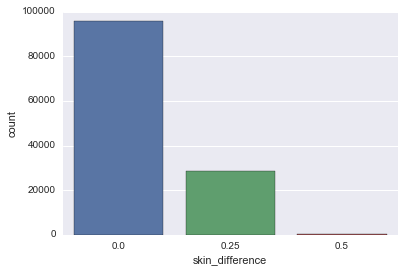

In [14]:
palette = sns.color_palette()
sns.countplot(x="skin_difference", data=skin_data);

If the two raters differ, it is only by one on the 5-point scale or by 2. We decide to keep the average value of the two raters on a 0 to 8 scale. (so that the average keep all the information)

In [15]:
skin_data['skin'] = skin_data.apply(lambda x: (x['rater1']+x['rater2'])/2*4, axis=1)

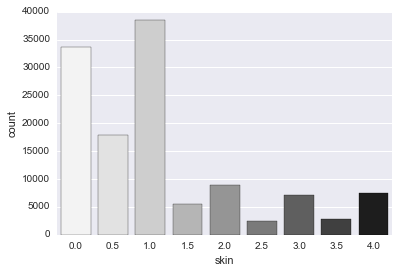

In [16]:
sns.countplot(x="skin", data=skin_data, palette=sns.color_palette("Greys", 9));

Since we are looking at data from countries with predominantly caucasion populations, it seems reasonable to have a larger white population.

### Age
There are not any missing birthday value. We will have a look at the age distribution.

In [17]:
# The birthday string is converted into a datetime type
import datetime
skin_data['birthday'] = skin_data.apply(lambda x: datetime.datetime.strptime(x['birthday'], "%d.%m.%Y"), axis=1)

In [18]:
skin_data['birthday'].head()

0   1983-08-31
1   1982-01-08
5   1979-11-08
6   1985-11-10
7   1986-04-04
Name: birthday, dtype: datetime64[ns]

In [19]:
import datetime as DT
now = pd.Timestamp(DT.datetime.now())
# We will plot the age in year of the players from their birthday
age = skin_data[['birthday']]
skin_data['age'] = age.apply(lambda x: int((now - x['birthday']).days/365.25) , axis=1)

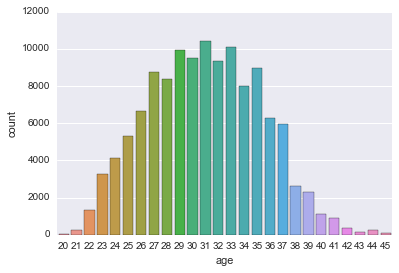

In [20]:
p = sns.countplot(x="age", data=skin_data)

Everything seems fine for the date values. Note that this is the distribution for the data non-aggregated by player. So it is reasonable to assume that older players, who have many more interactions with referees, appear many more times in this countplot than younger players, which is why the mean is surprisingly high.

### League Country

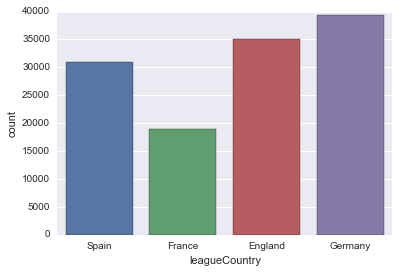

In [21]:
sns.countplot(x="leagueCountry", data=skin_data);

### Height

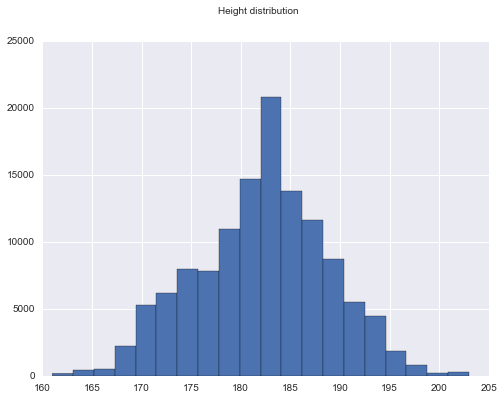

In [22]:
import matplotlib.ticker as ticker
f, ax = plt.subplots(figsize=(8,6))
heights = skin_data['height'].dropna()
plt.hist(heights, bins=20);
f.suptitle("Height distribution");

There is no outliers and the distribution looks normal.

### Weight

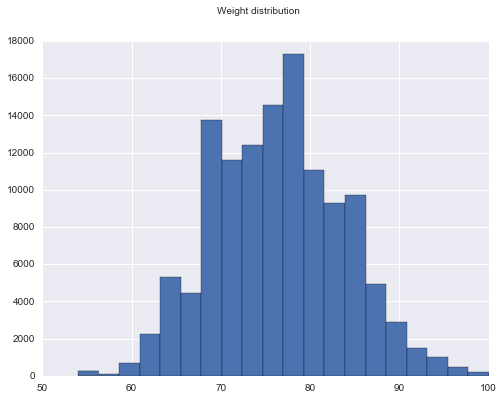

In [23]:
f, ax = plt.subplots(figsize=(8, 6))
plt.hist(skin_data.weight.dropna(), bins=20)
f.suptitle("Weight distribution");

### Position 

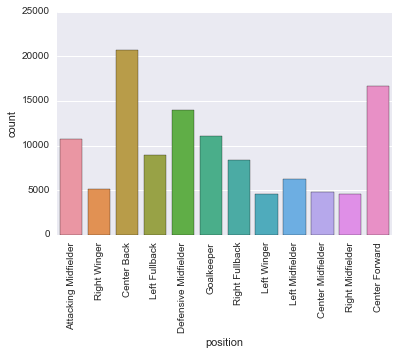

In [24]:
pos = sns.countplot(x="position", data=skin_data);
plt.setp(pos.get_xticklabels(), rotation=90);

In [25]:
missing_values = skin_data['position'].isnull().value_counts()

In [26]:
missing_values[1]/missing_values[0]

0.072870515627424276

7% of the positions are missing. We will replace them by the most by a category `Missing Position`.

### Referees

In [27]:
print('There are ' + str(len(skin_data['refNum'].value_counts())) + ' different referees.')

There are 2967 different referees.


In [28]:
print('Which come from ' + str(len(skin_data['refCountry'].value_counts())) + ' different countries...')

Which come from 155 different countries...


### Standardization, Categorical Features Encoding and Replacing Missing Values

We transform each feature into a representation that is more suitable for the machine learning methods. Each feature will be **standardized** if it is a float number (remove mean value, scale dividing by standard deviation) using the `StandardScaler()` function from `sklearn`. If there are missing values, they will be replaced by the mean, which is 0 after applying the StandardScaler. The categorical features will be **encoded** using the `LabelEncoder()` function which converts categorical variable into numerical values. The learning models consider continuous values and don't handle categorical features, but we hope RandomForest will be robust again those values. The missing categorical variables are replaced by `Missing Category`. We discard the name of the player, as well as the photoID and the birthday as it is a one to one relationship with the skin color.

In [29]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, Imputer 
from sklearn.feature_extraction import DictVectorizer

# Replacing missing values for categorical data:
skin_data['position'] = skin_data['position'].fillna('Missing Position')
# For the Alpha_3 there is only one missing value so we will drop it
skin_data = skin_data.dropna(subset=['Alpha_3'])

# Features to be standardized
stand = ['height', 'weight', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'redCards', 
         'yellowReds', 'age', 'skin', 'skin_difference', 'rater1', 'rater2']
# Categorical features to be encoded
cat = ['club', 'leagueCountry', 'position']

standardized = skin_data.copy()
standardized['skin_nonorm'] = standardized['skin']
# Encode categories
for c in cat:
    standardized[c] = LabelEncoder().fit_transform(standardized[c])

# The first function fills the missing values and the second one will apply the standardization 
for s in stand:
    standardized[s] = Imputer(strategy='mean', axis=1).fit_transform(standardized[s])[0]
    standardized[s] = StandardScaler().fit_transform(standardized[s])
    
     
# Discard names of players and photoID
skin_data_dropped = standardized.drop(labels=['playerShort', 'player', 'photoID', 'birthday', 'Alpha_3'], axis=1)

In [30]:
skin_data_dropped.head()

,club,leagueCountry,height,weight,position,games,victories,ties,defeats,goals,...,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skin_difference,skin,age,skin_nonorm
0,70,3,-0.753585,-0.609844,0,-0.557169,-0.714417,-0.625217,0.044463,-0.374371,...,0.326391,712.0,0.000564,0.396000,750.0,0.002696,1.800031,0.317661,0.459019,1.5
1,51,1,-0.459621,0.785575,12,-0.557169,-0.714417,-0.625217,0.044463,-0.374371,...,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,-0.547478,1.617787,0.687089,3.0
5,34,0,-0.018675,-0.749386,1,-0.557169,-0.714417,-0.625217,0.044463,-0.374371,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.800031,-0.549090,1.371299,0.5
6,48,0,0.716234,0.506492,6,-0.557169,-0.182707,-0.625217,-0.658021,-0.374371,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.800031,-0.549090,0.002879,0.5
7,54,0,-0.312639,-1.168011,4,-0.557169,-0.714417,-0.625217,0.044463,-0.374371,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,-0.547478,2.484538,-0.225191,4.0


# 1. Random Forest Skin Color Regressor

**We use Random Forest Regressor and Classifier because darkness of skin reflect a continuous value, we talked about it with Catasta on slack**

The most important parameters that can affect the accuracy of the random forest regressor are the number of trees in the forest `n_estimators`, the number of features to consider when looking for a best split `max_features`, the maximum depth of the tree `max_depth` and the minimum number of samples required to be at a leaf node `min_samples_leaf`. There are other parameters but we will have a closer look at those ones.

We seperate the data between the features used for prediction and the target features (skin). We need to drop the `rater1`, `rater2`, `skin` and `skin_difference` values as we want to predict the `skin`.

In [31]:
to_predict = ['rater1', 'rater2', 'skin', 'skin_difference', 'skin_nonorm']
data = skin_data_dropped.drop(labels=to_predict, axis=1)
features = data.columns

# Skin to predict
target = grouped.skin_nonorm.apply(lambda x: x/4.0).values.ravel() 


First, all the columns will be used to train the Random Forest Classifier.

### n_estimators
We will test the accuracy of the model for different number of trees. We use 5-folds cross validation to measure the accuracy of the predictive model, we use the mean of the accuracy over the 5 folds to tune the parameters.

In [32]:
from sklearn.metrics import accuracy_score
from sklearn import model_selection

In [33]:
number_trees = [5,10,20,50,100,200]
accuracy = []

for t in number_trees:
    tree = RandomForestRegressor(n_estimators=t)
    scores = model_selection.cross_val_score(tree, data, target, cv=5)
    accuracy.append(scores.mean())

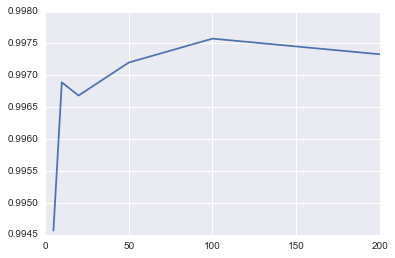

In [34]:
plt.plot(number_trees, accuracy);

Higher number of trees will avoid overfitting (because the model takes the maximum voting of predictions) and give more stable predictions but it takes the model longer to fit the data.

However, notice that this accuracy is impossibly high, which makes sense when we consider that each player appears multiple times in the dataset, due to their presence in multiple dyads. So players will be recognised due to their almost unique personal characteristics (e.g. height, weight, age, position, club). 

### Rethinking the data - aggregation

In order to get more reasonable results and train our model to recognise unseen players, we group on each player and aggregate the information.

We can add some other features on top of the aggregated means of these columns

In [35]:
# Weighted means of the meanIAT and meanExp measures
standardized['weightMeanIAT'] = standardized.meanIAT * standardized.nIAT / standardized.nIAT.sum()
standardized['weightMeanExp'] = standardized.meanExp * standardized.nExp / standardized.nExp.sum()
unique_count = lambda df: len(df.unique())
agg_stderr = lambda df: math.sqrt(np.mean(df**2))

In [36]:
f = {'skin': 'mean', 'skin_difference': 'mean', 'skin_nonorm': 'mean', 'meanIAT': 'mean', 'meanExp': 'mean', 
     'weight': 'mean', 'height': 'mean', 'age': 'mean', 'games': 'mean', 'victories': 'mean', 'ties': 'mean', 
     'defeats': 'mean', 'goals': 'mean', 'yellowCards': 'mean', 'yellowReds': 'mean', 'redCards': 'mean', 
     'refNum': unique_count, 'refCountry': unique_count, 'seIAT': agg_stderr, 'seExp': agg_stderr, 
     'weightMeanIAT': 'mean', 'weightMeanExp': 'mean', 'position': 'mean'}

In [37]:
grouped = standardized.groupby('playerShort').agg(f)

Let's split the data into the feature set and the target data.

We convert here the skin values to integers in $\{0,1\}$, so if we compare it with a classifier, we have a total of 2 classes.

In [92]:
to_predict = ['skin', 'skin_difference', 'skin_nonorm']

# Features
data = grouped.drop(labels=to_predict, axis=1)
features = data.columns


### Feature correlation matrix

Before looking into training and tuning the model, it is interesting to look at the relations between features. To this end, we plotted a feature-correlation matrix.

In [39]:
def correlation_matrix(df, title):
    """Plot the pairwise correlations in df"""
    sns.set(style="white")
    corr = df.corr(method='pearson')
 
    # Generate a mask for the upper triangle 
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
 
    # Set up the matplotlib figure 
    f, ax = plt.subplots(figsize=(11, 9))
 
    # Generate a custom diverging colormap 
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
 
    # Draw the heatmap with the mask and correct aspect ratio 
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, square=True,
                linewidths=.5, cbar_kws={"shrink": .8}, ax=ax)
 
    # Rename the labels (movement_activity_i -> mi, stationarity_i -> si) 
    curr_labels = [item.get_text() for item in ax.get_xticklabels()]
    split_labels = [str.split(label, '_') for label in curr_labels]
    labels = [lst[0][0]+lst[-1] for lst in split_labels] # shortening the name 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(reversed(labels))
 
    # Set title 
    f.suptitle(title, fontsize=18)

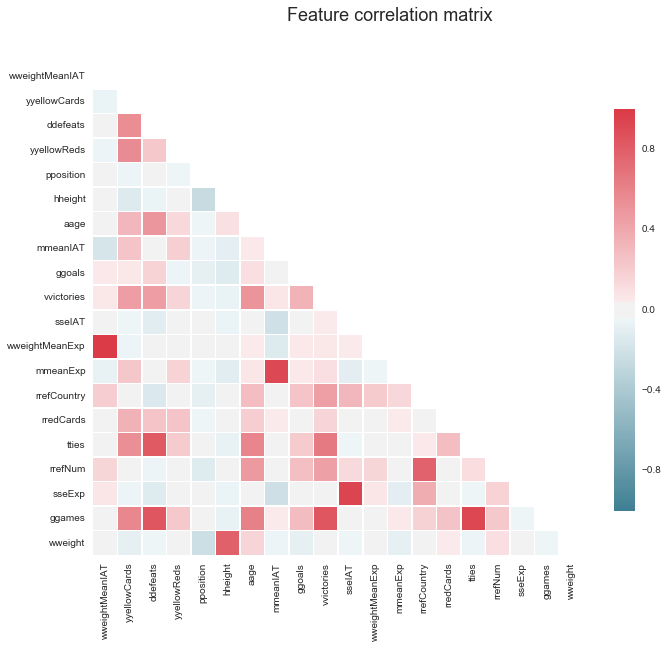

In [40]:
correlation_matrix(data, "Feature correlation matrix")

Some of the features show an obvious correlation with others (e.g. `games` has a strong positive correlation with `ties`, `victories`, `defeats`). Other than these obvious connections, the correlation matrix doesn't show any surprising correlations.

### `n_estimators` with aggregated data

With the grouping on players and aggregation of the features done, let's recompute the score with varying `n_estimators` parameter for our `RandomForestRegressor`.

In [41]:
number_trees = [1,5,10,20,50,100,200]
score = []

for t in number_trees:
    tree = RandomForestRegressor(n_estimators=t)
    scores = model_selection.cross_val_score(tree, data, target, cv=5)
    score.append(scores.mean())

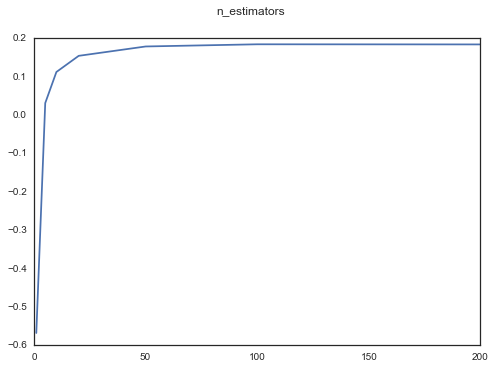

In [42]:
plt.plot(number_trees, score)
plt.suptitle("n_estimators");

The negative score can seem alarming at first, but `RandomForestRegressor`'s `score` function computes the score differently than that of a `RandomForestClassifier`, as is explained in the [doc](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.score). It uses the $R^2$ regression score function (aka coefficient of determination). 

The negative score values indicate that there is a constant model that performs better than ours, with low values of `n_estimators`, which is understandable given the distribution of our data (many more white players than not).

From the progression of the accuracy here, we can see that a good value for `n_estimators` is 100.

### Random Forest accuracy
In order to better understand the performance of our Regressor, we can convert the output so that it corresponds to that of a classifier.

In [68]:
def predict_class_from_reg(model, X, y, test):
    """Returns the predictions of a RandomForestRegressor rounded so as to have classes as output."""
    model.fit(X, y)
    predictions = model.predict(test)
    return np.around(predictions)

In [69]:
def rf_accuracy(model, data, target):
    """Returns the accuracy of a model over a split.
    Rounds the predictions to the """
    x_train, x_test, y_train, y_test = model_selection.train_test_split(data, target, test_size=0.1, random_state=42)
    rounded_pred = predict_class_from_reg(model, x_train, y_train, x_test)
    return np.sum(np.equal(rounded_pred, y_test)) / float(len(y_test))

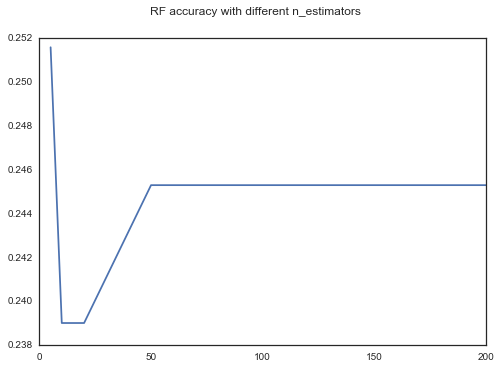

In [70]:
number_trees = [5,10,20,50,100,200]
accuracy = []

for t in number_trees:
    tree = RandomForestRegressor(n_estimators=t)
    accuracy.append(rf_accuracy(tree, data, target))

plt.plot(number_trees, accuracy)
plt.suptitle("RF accuracy with different n_estimators");

*Note* that this is the result of only one train-test split, so not a viable judge for determining stable and efficient parameters. This is noticeable by running the cell above several times, and we see the shape of the curve change quite a lot. The result of the actual score plotted previously is far more reliable.

### max_features
As default, the number of features to consider when looking for the best split is equal to the square root of the number of features. We will test it with different values between 1 and the number of features.

In [46]:
max_features = range(1,len(features)+1)
score = []

for m in max_features:
    tree = RandomForestRegressor(n_estimators=100, max_features=m)
    scores = model_selection.cross_val_score(tree, data, target, cv=10)
    score.append(scores.mean())

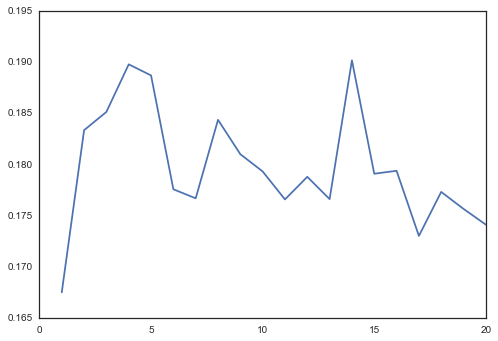

In [47]:
plt.plot(max_features, score);

A good and stable choice for max_features seems to be 5.


### max_depth
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure. We compute the score for several depths, including the default value (indicated by `None`).

In [48]:
# None included to compute 
max_depths = [1,5,10,20,50,75]
accuracy = []

for d in max_depths:
    tree = RandomForestRegressor(n_estimators=100, max_features=5, max_depth=d)
    scores = model_selection.cross_val_score(tree, data, target, cv=10)
    accuracy.append(scores.mean())

In [49]:
tree = RandomForestRegressor(n_estimators=100, max_features=5, max_depth=None)
scores = model_selection.cross_val_score(tree, data, target, cv=10)
accuracy.append(scores.mean())

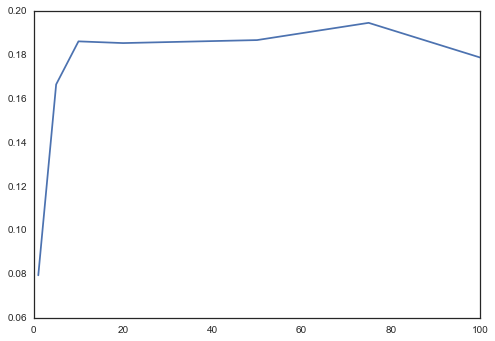

In [50]:
max_depths.append(100) # 100 represents the default value
plt.plot(max_depths, accuracy);

In our case, there is no overfitting problem with a tree having pure nodes. We will keep the default value.

In [51]:
rf_accuracy(RandomForestRegressor(n_estimators=100, max_features=5, max_depth=None), data, target)

0.24528301886792453

### min_samples_leaf
The minimum number of samples required to be at a leaf node.

In [52]:
min_samples = [1,2,3,4,5,10,20]
accuracy = []

for s in min_samples:
    tree = RandomForestRegressor(n_estimators=100, max_features=5, min_samples_leaf=s)
    scores = model_selection.cross_val_score(tree, data, target, cv=5)
    accuracy.append(scores.mean())

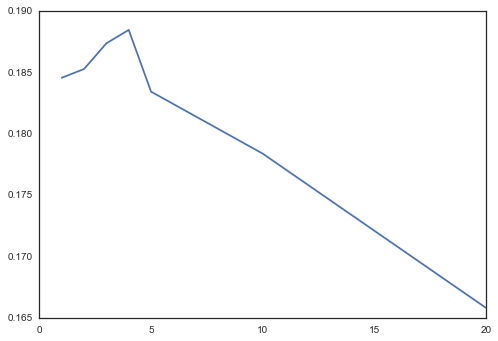

In [53]:
plt.plot(min_samples, accuracy);

If less than 3 samples are in a leaf the model is overfitting and if more than 3 are in a leaf node it is underfitting.

### Feature importance of the trained model

Now we will have a look at the features sorted by their score in the tree with the tuned parameter we found.

In [54]:
def features_importance_rf(X, y, rf, print_=True, plot=True):
    """Print and plot the top features importances in X using the rf classifier.
    Returns columns names in order of increasing importance"""
    rf.fit(X, y)
 
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
 
    cols = X.columns
    ord_cols = []
    # Print the feature ranking 
    if print_:
        print("Feature ranking:")
 
        for f in range(X.shape[1]):
            print("%d. feature n° %d %s (%f)" % (f + 1, indices[f], cols[indices[f]], importances[indices[f]]))
            ord_cols.append(cols[indices[f]])
    else:
        for f in range(X.shape[1]):
            ord_cols.append(cols[indices[f]])  
 
    # Plot the feature importance 
    if plot:
        plt.subplots(figsize=(8,6))
        plt.suptitle("Feature importance", fontsize=18)
        plt.bar(range(X.shape[1]), importances[indices],
               color="r", yerr=std[indices], align="center")
        plt.xticks(range(X.shape[1]), indices)
        plt.xlim([-1, X.shape[1]])
        plt.show()
        
    # Compute accuracy
    print("Accuracy:", rf_accuracy(rf, X, y))
 
    return ord_cols

The red bars in the plot represent the feature importance of the trees and the blue lines are the inter-tree variability.

Feature ranking:
1. feature n° 17 seExp (0.111192)
2. feature n° 10 seIAT (0.099173)
3. feature n° 7 meanIAT (0.092432)
4. feature n° 12 meanExp (0.086080)
5. feature n° 16 refNum (0.052364)
6. feature n° 9 victories (0.051633)
7. feature n° 8 goals (0.050685)
8. feature n° 1 yellowCards (0.047039)
9. feature n° 18 games (0.043604)
10. feature n° 2 defeats (0.041413)
11. feature n° 15 ties (0.041210)
12. feature n° 13 refCountry (0.038659)
13. feature n° 14 redCards (0.035261)
14. feature n° 4 position (0.032489)
15. feature n° 5 height (0.032448)
16. feature n° 6 age (0.031543)
17. feature n° 19 weight (0.030912)
18. feature n° 0 weightMeanIAT (0.029564)
19. feature n° 11 weightMeanExp (0.027965)
20. feature n° 3 yellowReds (0.024335)


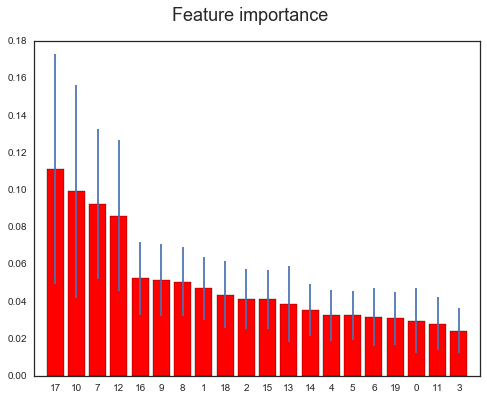

Accuracy: 0.238993710692


In [86]:
rf = RandomForestRegressor(n_estimators=100, max_features=5, min_samples_leaf=3)
sorted_features = features_importance_rf(data, target, rf)

The four highest ranked features are the aggregated standard errors and mean scores of the explicit and implicit racism tests. We can also see that these four features have the highest inter-tree variability. 

Let's see what happens if we remove these top four features.

Feature ranking:
1. feature n° 8 victories (0.089274)
2. feature n° 7 goals (0.080453)
3. feature n° 1 yellowCards (0.078587)
4. feature n° 10 refCountry (0.077323)
5. feature n° 13 refNum (0.076270)
6. feature n° 14 games (0.074552)
7. feature n° 12 ties (0.071614)
8. feature n° 2 defeats (0.067530)
9. feature n° 11 redCards (0.058193)
10. feature n° 15 weight (0.056369)
11. feature n° 5 height (0.055318)
12. feature n° 9 weightMeanExp (0.051111)
13. feature n° 0 weightMeanIAT (0.042531)
14. feature n° 4 position (0.041685)
15. feature n° 3 yellowReds (0.040785)
16. feature n° 6 age (0.038406)


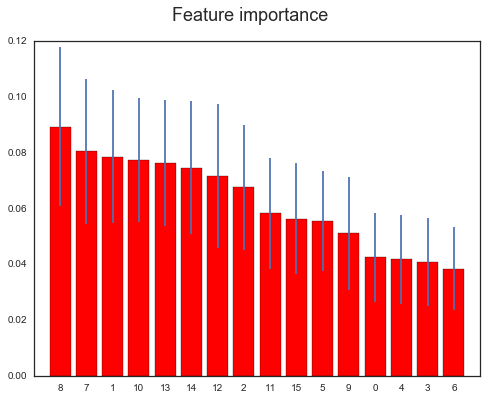

Accuracy: 0.22641509434


In [56]:
reduced_data = data.drop(sorted_features[:4], axis=1)
rf_red = RandomForestRegressor(n_estimators=100, max_features=5, min_samples_leaf=3)
reduced_sorted_features = features_importance_rf(reduced_data, target, rf_red)

So by removing the features with highest importance, we get an accuracy of about $16\%$ instead of $26\%$. Even though the importance measures (red bars) increased slightly, the order of the feature importances measured seem quite stable.

### Confusion Matrix

With the help of a confusion matrix, we can look at the way our 'classifier' (rounded regressor predictions) labels the OOB objects it receives.

In [57]:
from sklearn.metrics import confusion_matrix
import itertools

In [58]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    np.set_printoptions(precision=2)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

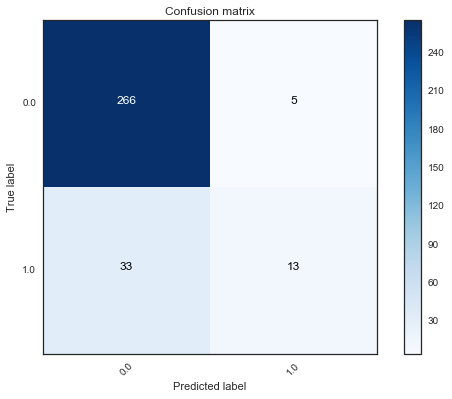

In [74]:
# Our model with best parameters according to our previous tests
rf = RandomForestRegressor(n_estimators=100, max_features=5, min_samples_leaf=3)
# Data split 
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, target, test_size=0.2)
predictions = predict_class_from_reg(rf, x_train, y_train, x_test)
rounded_y = np.around(y_test)
cm = confusion_matrix(rounded_y, predictions)
classes = np.unique(rounded_y)
plot_confusion_matrix(cm, classes)

Our model performs best at predicting players with skin-tone $2.0$ (average rater score of $0.25$ on the original scale). It is also noticeably worse at classifying dark-skinned players than light-skinned ones, which is understandable given the skewed nature of our data (i.e. many more white players present in the set).

# Bonus

In [80]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve."""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = model_selection.learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/opt/anaconda/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    165         sys.exit(msg)
    166     main_globals = sys.modules["__main__"].__dict__
    167     if alter_argv:
    168         sys.argv[0] = mod_spec.origin
    169     return _run_code(code, main_globals, None,
--> 170                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py')
    171 
    172 def run_module(mod_name, init_globals=None,
    173                run_name=None, alter_sys=False):
    174     """Execute a module's code without importing it

...........................................................................
/opt/anaconda/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7faa9cd1e1e0, file "/...3.5/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/opt/anaconda/lib/python3.5/site-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/opt/anacond.../python3.5/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7faa9cd1e1e0, file "/...3.5/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/opt/anaconda/lib/python3.5/site-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/opt/anacond.../python3.5/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    591         
    592         If a global instance already exists, this reinitializes and starts it
    593         """
    594         app = cls.instance(**kwargs)
    595         app.initialize(argv)
--> 596         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    597 
    598 #-----------------------------------------------------------------------------
    599 # utility functions, for convenience
    600 #-----------------------------------------------------------------------------

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    437         
    438         if self.poller is not None:
    439             self.poller.start()
    440         self.kernel.start()
    441         try:
--> 442             ioloop.IOLoop.instance().start()
    443         except KeyboardInterrupt:
    444             pass
    445 
    446 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    878                 self._events.update(event_pairs)
    879                 while self._events:
    880                     fd, events = self._events.popitem()
    881                     try:
    882                         fd_obj, handler_func = self._handlers[fd]
--> 883                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    884                     except (OSError, IOError) as e:
    885                         if errno_from_exception(e) == errno.EPIPE:
    886                             # Happens when the client closes the connection
    887                             pass

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'cv = model_selection.ShuffleSplit(n_splits=100, ...ta, target, \n                    cv=cv, n_jobs=4)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-11-22T18:02:08.322189', 'msg_id': '7E6EE65A8CCF4F8FA77B1B5814795F86', 'msg_type': 'execute_request', 'session': '545C61A99B8B4B129C999194C6031CBA', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '7E6EE65A8CCF4F8FA77B1B5814795F86', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'545C61A99B8B4B129C999194C6031CBA']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'cv = model_selection.ShuffleSplit(n_splits=100, ...ta, target, \n                    cv=cv, n_jobs=4)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-11-22T18:02:08.322189', 'msg_id': '7E6EE65A8CCF4F8FA77B1B5814795F86', 'msg_type': 'execute_request', 'session': '545C61A99B8B4B129C999194C6031CBA', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '7E6EE65A8CCF4F8FA77B1B5814795F86', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'545C61A99B8B4B129C999194C6031CBA'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'cv = model_selection.ShuffleSplit(n_splits=100, ...ta, target, \n                    cv=cv, n_jobs=4)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-11-22T18:02:08.322189', 'msg_id': '7E6EE65A8CCF4F8FA77B1B5814795F86', 'msg_type': 'execute_request', 'session': '545C61A99B8B4B129C999194C6031CBA', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '7E6EE65A8CCF4F8FA77B1B5814795F86', 'msg_type': 'execute_request', 'parent_header': {}})
    386         if not silent:
    387             self.execution_count += 1
    388             self._publish_execute_input(code, parent, self.execution_count)
    389 
    390         reply_content = self.do_execute(code, silent, store_history,
--> 391                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    392 
    393         # Flush output before sending the reply.
    394         sys.stdout.flush()
    395         sys.stderr.flush()

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='cv = model_selection.ShuffleSplit(n_splits=100, ...ta, target, \n                    cv=cv, n_jobs=4)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    194 
    195         reply_content = {}
    196         # FIXME: the shell calls the exception handler itself.
    197         shell._reply_content = None
    198         try:
--> 199             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method InteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'cv = model_selection.ShuffleSplit(n_splits=100, ...ta, target, \n                    cv=cv, n_jobs=4)'
        store_history = True
        silent = False
    200         except:
    201             status = u'error'
    202             # FIXME: this code right now isn't being used yet by default,
    203             # because the run_cell() call above directly fires off exception

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='cv = model_selection.ShuffleSplit(n_splits=100, ...ta, target, \n                    cv=cv, n_jobs=4)', store_history=True, silent=False, shell_futures=True)
   2718                 self.displayhook.exec_result = result
   2719 
   2720                 # Execute the user code
   2721                 interactivity = "none" if silent else self.ast_node_interactivity
   2722                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2723                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2724 
   2725                 # Reset this so later displayed values do not modify the
   2726                 # ExecutionResult
   2727                 self.displayhook.exec_result = None

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-79-7c55b16bf77a>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2826                     return True
   2827 
   2828             for i, node in enumerate(to_run_interactive):
   2829                 mod = ast.Interactive([node])
   2830                 code = compiler(mod, cell_name, "single")
-> 2831                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7faa5bce1540, file "<ipython-input-79-7c55b16bf77a>", line 4>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   2832                     return True
   2833 
   2834             # Flush softspace
   2835             if softspace(sys.stdout, 0):

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7faa5bce1540, file "<ipython-input-79-7c55b16bf77a>", line 4>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2880         outflag = 1  # happens in more places, so it's easier as default
   2881         try:
   2882             try:
   2883                 self.hooks.pre_run_code_hook()
   2884                 #rprint('Running code', repr(code_obj)) # dbg
-> 2885                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7faa5bce1540, file "<ipython-input-79-7c55b16bf77a>", line 4>
        self.user_global_ns = {'DT': <module 'datetime' from '/opt/anaconda/lib/python3.5/datetime.py'>, 'DictVectorizer': <class 'sklearn.feature_extraction.dict_vectorizer.DictVectorizer'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', "import pandas as pd\nimport numpy as np \nfrom skl...nline')\npd.options.mode.chained_assignment = None", "data = pd.read_csv('CrowdstormingDataJuly1st.csv')\ndata.ix[:5,:14]", 'data.ix[:5,14:]', 'data.isnull().sum()', 'filtered = data.dropna()', 'len(filtered)/len(data)', 'len(data[data.rater1.isnull() & (data.rater2.isnull())])/len(data)', "skin_data = data.dropna(how='all', subset=['rater1','rater2'])", "skin_data = skin_data.dropna(how='all', subset=['meanIAT', 'nIAT'])", 'len(skin_data[skin_data.rater1.isnull() | (skin_data.rater2.isnull())])', 'skin_data_differ = skin_data[skin_data.rater1 != skin_data.rater2]', 'len(skin_data_differ)/len(skin_data)', "skin_data['skin_difference'] = skin_data.apply(lambda x: abs(x['rater1'] - x['rater2']), axis=1)", 'palette = sns.color_palette()\nsns.countplot(x="skin_difference", data=skin_data);', "skin_data['skin'] = skin_data.apply(lambda x: (x['rater1']+x['rater2'])/2*4, axis=1)", 'sns.countplot(x="skin", data=skin_data, palette=sns.color_palette("Greys", 9));', '# The birthday string is converted into a dateti...time.strptime(x[\'birthday\'], "%d.%m.%Y"), axis=1)', "skin_data['birthday'].head()", "import datetime as DT\nnow = pd.Timestamp(DT.date... int((now - x['birthday']).days/365.25) , axis=1)", ...], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'Out': {2:      playerShort         player             club... 
4      0            0  
5      0            0  , 3:    yellowReds  redCards    photoID  rater1  rate...5   127.0  0.003297  0.538462   130.0  0.013752  , 4: playerShort          0
player               0
cl...          163
seExp              163
dtype: int64, 6: 0.790649738406333, 7: 0.14659517352836443, 10: 0, 12: 0.23189896198219623, 18: 0   1983-08-31
1   1982-01-08
5   1979-11-08
6  ... 1986-04-04
Name: birthday, dtype: datetime64[ns], 26: 0.072870515627424276, 30:    club  leagueCountry    height    weight  posi...8 -0.225191          4.0  

[5 rows x 27 columns], ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomForestRegressor': <class 'sklearn.ensemble.forest.RandomForestRegressor'>, 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, '_': playerShort
aaron-hughes              1
aaron-hu...-el-kaoutari    1
Name: skin_nonorm, dtype: int64, ...}
        self.user_ns = {'DT': <module 'datetime' from '/opt/anaconda/lib/python3.5/datetime.py'>, 'DictVectorizer': <class 'sklearn.feature_extraction.dict_vectorizer.DictVectorizer'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', "import pandas as pd\nimport numpy as np \nfrom skl...nline')\npd.options.mode.chained_assignment = None", "data = pd.read_csv('CrowdstormingDataJuly1st.csv')\ndata.ix[:5,:14]", 'data.ix[:5,14:]', 'data.isnull().sum()', 'filtered = data.dropna()', 'len(filtered)/len(data)', 'len(data[data.rater1.isnull() & (data.rater2.isnull())])/len(data)', "skin_data = data.dropna(how='all', subset=['rater1','rater2'])", "skin_data = skin_data.dropna(how='all', subset=['meanIAT', 'nIAT'])", 'len(skin_data[skin_data.rater1.isnull() | (skin_data.rater2.isnull())])', 'skin_data_differ = skin_data[skin_data.rater1 != skin_data.rater2]', 'len(skin_data_differ)/len(skin_data)', "skin_data['skin_difference'] = skin_data.apply(lambda x: abs(x['rater1'] - x['rater2']), axis=1)", 'palette = sns.color_palette()\nsns.countplot(x="skin_difference", data=skin_data);', "skin_data['skin'] = skin_data.apply(lambda x: (x['rater1']+x['rater2'])/2*4, axis=1)", 'sns.countplot(x="skin", data=skin_data, palette=sns.color_palette("Greys", 9));', '# The birthday string is converted into a dateti...time.strptime(x[\'birthday\'], "%d.%m.%Y"), axis=1)', "skin_data['birthday'].head()", "import datetime as DT\nnow = pd.Timestamp(DT.date... int((now - x['birthday']).days/365.25) , axis=1)", ...], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'Out': {2:      playerShort         player             club... 
4      0            0  
5      0            0  , 3:    yellowReds  redCards    photoID  rater1  rate...5   127.0  0.003297  0.538462   130.0  0.013752  , 4: playerShort          0
player               0
cl...          163
seExp              163
dtype: int64, 6: 0.790649738406333, 7: 0.14659517352836443, 10: 0, 12: 0.23189896198219623, 18: 0   1983-08-31
1   1982-01-08
5   1979-11-08
6  ... 1986-04-04
Name: birthday, dtype: datetime64[ns], 26: 0.072870515627424276, 30:    club  leagueCountry    height    weight  posi...8 -0.225191          4.0  

[5 rows x 27 columns], ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomForestRegressor': <class 'sklearn.ensemble.forest.RandomForestRegressor'>, 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, '_': playerShort
aaron-hughes              1
aaron-hu...-el-kaoutari    1
Name: skin_nonorm, dtype: int64, ...}
   2886             finally:
   2887                 # Reset our crash handler in place
   2888                 sys.excepthook = old_excepthook
   2889         except SystemExit as e:

...........................................................................
/home/atoll/adaepfl-hw/04 - Applied ML/<ipython-input-79-7c55b16bf77a> in <module>()
      1 
      2 cv = model_selection.ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
      3 title = "Learning curve"
      4 rf = RandomForestClassifier(n_estimators=100, max_features=5, min_samples_leaf=3)
----> 5 plot_learning_curve(rf, title, data, target, 
      6                     cv=cv, n_jobs=4)
      7 
      8 
      9 
     10 

...........................................................................
/home/atoll/adaepfl-hw/04 - Applied ML/<ipython-input-75-9b5c521f78ac> in plot_learning_curve(estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), title='Learning curve', X=                        weightMeanIAT  yellowCar....280347  2.274077e-01  

[1585 rows x 20 columns], y=array([ 0.12,  0.12,  0.25, ...,  0.88,  0.  ,  0.  ]), ylim=None, cv=ShuffleSplit(n_splits=100, random_state=0, test_size=0.2, train_size=None), n_jobs=4, train_sizes=array([ 0.1 ,  0.33,  0.55,  0.78,  1.  ]))
      5     if ylim is not None:
      6         plt.ylim(*ylim)
      7     plt.xlabel("Training examples")
      8     plt.ylabel("Score")
      9     train_sizes, train_scores, test_scores = model_selection.learning_curve(
---> 10         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
     11     train_scores_mean = np.mean(train_scores, axis=1)
     12     train_scores_std = np.std(train_scores, axis=1)
     13     test_scores_mean = np.mean(test_scores, axis=1)
     14     test_scores_std = np.std(test_scores, axis=1)

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in learning_curve(estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), X=                        weightMeanIAT  yellowCar....280347  2.274077e-01  

[1585 rows x 20 columns], y=array([ 0.12,  0.12,  0.25, ...,  0.88,  0.  ,  0.  ]), groups=None, train_sizes=array([ 0.1 ,  0.33,  0.55,  0.78,  1.  ]), cv=ShuffleSplit(n_splits=100, random_state=0, test_size=0.2, train_size=None), scoring=None, exploit_incremental_learning=False, n_jobs=4, pre_dispatch='all', verbose=0)
    767             scorer, verbose) for train, test in cv_iter)
    768     else:
    769         out = parallel(delayed(_fit_and_score)(
    770             clone(estimator), X, y, scorer, train[:n_train_samples], test,
    771             verbose, parameters=None, fit_params=None, return_train_score=True)
--> 772             for train, test in cv_iter
        cv_iter = [(array([ 215, 1180,   55, ..., 1216,  559,  684]), array([ 944, 1032,  893,  667, 1257, 1236,  182,... 1426,  801,  641,  519,  381,  748,  231,  390])), (array([ 547, 1009, 1472, ...,  407,    5,   55]), array([1094,  641, 1558,  575,  117, 1169,  741,... 1388, 1329, 1421,  769, 1262, 1522,  180, 1298])), (array([  95,  302, 1117, ...,  425, 1316,  824]), array([ 140,  629,  973,  886,  359,  560,  105,...  719,  823,  901,  380,  449, 1242,  556,  464])), (array([1207, 1094,  715, ...,   38,  158, 1302]), array([ 845, 1375,  451,  811, 1440,  875, 1442,...  593,  126, 1498,  404,  572,  888,  354,  528])), (array([1567,  881, 1548, ..., 1387, 1167,  974]), array([1513,  526, 1052,  382,  423, 1403,  883,...  977, 1079,  728,  940,  392,  792,   75, 1235])), (array([1554,  204,  843, ..., 1314,  987, 1419]), array([1177,  530,  682,  242, 1128,    3,  292,... 1473, 1285, 1230,  352, 1507,   33,  751,  462])), (array([1556,  192,   76, ...,  268,  650, 1067]), array([ 486, 1262, 1405, 1253, 1155, 1085,  851,... 1172,  643,  646,  912,  579,  668,  952, 1432])), (array([ 495,  158,   98, ..., 1237,  631,  474]), array([ 193,  959, 1482,  976, 1394, 1050, 1504,... 1293, 1413,  579,  206,  514, 1512,  218,  177])), (array([1431,  394, 1017, ..., 1508,    6, 1383]), array([ 131,  966,  860, 1032,  500,  715, 1284,...  786, 1513,  121, 1144, 1035,  409, 1463, 1582])), (array([1574, 1257,  367, ...,  805,  495,  984]), array([ 424, 1495,  566, 1114, 1118,  643,  459,...  326,  557,  770, 1387, 1414, 1136,   51,  435])), (array([1562,  484, 1457, ...,  355,  534,  808]), array([  16, 1492, 1028, 1134,  960,  123, 1365,...  726,  604, 1001,   18, 1500,  245,  600,  969])), (array([ 248, 1371,  686, ..., 1563, 1568,  890]), array([ 637, 1116,  409,  355,  665,  664,  640,...  709,  763,  841, 1268,   74,   44,  230,  857])), (array([1106,  801,  376, ...,   92,  712, 1074]), array([1235, 1264,   56,  709, 1302, 1149,  681,...  470,   79,  124, 1437,  840, 1568, 1239, 1549])), (array([ 944,  488,  299, ...,  992, 1291, 1387]), array([ 298,  385,  149,  326,  717,  159,  134,...   43,  224,  322, 1523,  990,  384,  200, 1559])), (array([1162,  840,  992, ...,  684, 1395,  368]), array([  51,  397, 1207,  168,  296,  741,  843,...  982, 1554,  983, 1186,  911, 1417, 1195,  765])), (array([ 847, 1081, 1311, ...,  419,  968,  359]), array([ 155, 1225,  408,  535, 1369, 1204, 1223,... 1395,  987, 1067, 1128, 1346,  315, 1082,  951])), (array([ 533, 1131,  911, ...,  729, 1241,  738]), array([ 135,  674,  406,  498,  969, 1202,  951,...   43,  231,  409,  437,   85,   83, 1399,  972])), (array([ 675, 1185, 1240, ..., 1184, 1345,  461]), array([ 585, 1045,  767,  271,  121,  899,  932,... 1142, 1362, 1186,  949,  935,  516, 1563,  866])), (array([1369, 1307,  660, ...,  694, 1303, 1125]), array([ 513,  637, 1222,  561, 1199,  844, 1532,...   61, 1097, 1415,  418, 1450,  985, 1287,  807])), (array([572, 567, 904, ..., 885,  10, 300]), array([ 780,  670, 1133, 1127,  534,  279,  276,...  519,  162,  368, 1408, 1419, 1559,  287,  539])), ...]
    773             for n_train_samples in train_sizes_abs)
    774         out = np.array(out)
    775         n_cv_folds = out.shape[0] // n_unique_ticks
    776         out = out.reshape(n_cv_folds, n_unique_ticks, 2)

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object learning_curve.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Tue Nov 22 18:02:08 2016
PID: 2493                            Python 3.5.1: /opt/anaconda/bin/python
...........................................................................
/opt/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False),                         weightMeanIAT  yellowCar....280347  2.274077e-01  

[1585 rows x 20 columns], array([ 0.12,  0.12,  0.25, ...,  0.88,  0.  ,  0.  ]), <function _passthrough_scorer>, array([ 215, 1180,   55, 1136,  578, 1584,  984,... 198, 1470,
       1322,  737,  913, 1159,  511]), array([ 944, 1032,  893,  667, 1257, 1236,  182,... 1426,  801,  641,  519,  381,  748,  231,  390]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False),                         weightMeanIAT  yellowCar....280347  2.274077e-01  

[1585 rows x 20 columns], array([ 0.12,  0.12,  0.25, ...,  0.88,  0.  ,  0.  ]), <function _passthrough_scorer>, array([ 215, 1180,   55, 1136,  578, 1584,  984,... 198, 1470,
       1322,  737,  913, 1159,  511]), array([ 944, 1032,  893,  667, 1257, 1236,  182,... 1426,  801,  641,  519,  381,  748,  231,  390]), 0)
        kwargs = {'fit_params': None, 'parameters': None, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), X=                        weightMeanIAT  yellowCar....280347  2.274077e-01  

[1585 rows x 20 columns], y=array([ 0.12,  0.12,  0.25, ...,  0.88,  0.  ,  0.  ]), scorer=<function _passthrough_scorer>, train=array([ 215, 1180,   55, 1136,  578, 1584,  984,... 198, 1470,
       1322,  737,  913, 1159,  511]), test=array([ 944, 1032,  893,  667, 1257, 1236,  182,... 1426,  801,  641,  519,  381,  748,  231,  390]), verbose=0, parameters=None, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=False, return_times=False, error_score='raise')
    233 
    234     try:
    235         if y_train is None:
    236             estimator.fit(X_train, **fit_params)
    237         else:
--> 238             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseForest.fit of RandomForestClas...e=None,
            verbose=0, warm_start=False)>
        X_train =                      weightMeanIAT  yellowCards ...         -6.098438e-01  

[126 rows x 20 columns]
        y_train = array([ 0.25,  0.25,  0.25,  0.12,  0.  ,  0.  ,... 0.25,  0.25,  0.25,  0.  ,  0.  ,  1.  ,  0.5 ])
        fit_params = {}
    239 
    240     except Exception as e:
    241         # Note fit time as time until error
    242         fit_time = time.time() - start_time

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py in fit(self=RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), X=array([[  3.79e-07,   6.29e-01,   2.67e-01, ...,...   4.41e-01,
         -6.10e-01]], dtype=float32), y=array([[ 0.25],
       [ 0.25],
       [ 0.25],
...
       [ 0.  ],
       [ 1.  ],
       [ 0.5 ]]), sample_weight=None)
    266             # [:, np.newaxis] that does not.
    267             y = np.reshape(y, (-1, 1))
    268 
    269         self.n_outputs_ = y.shape[1]
    270 
--> 271         y, expanded_class_weight = self._validate_y_class_weight(y)
        y = array([[ 0.25],
       [ 0.25],
       [ 0.25],
...
       [ 0.  ],
       [ 1.  ],
       [ 0.5 ]])
        expanded_class_weight = undefined
        self._validate_y_class_weight = <bound method ForestClassifier._validate_y_class...e=None,
            verbose=0, warm_start=False)>
    272 
    273         if getattr(y, "dtype", None) != DOUBLE or not y.flags.contiguous:
    274             y = np.ascontiguousarray(y, dtype=DOUBLE)
    275 

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py in _validate_y_class_weight(self=RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), y=array([[ 0.25],
       [ 0.25],
       [ 0.25],
...
       [ 0.  ],
       [ 1.  ],
       [ 0.5 ]]))
    452             self.oob_decision_function_ = oob_decision_function
    453 
    454         self.oob_score_ = oob_score / self.n_outputs_
    455 
    456     def _validate_y_class_weight(self, y):
--> 457         check_classification_targets(y)
        y = array([[ 0.25],
       [ 0.25],
       [ 0.25],
...
       [ 0.  ],
       [ 1.  ],
       [ 0.5 ]])
    458 
    459         y = np.copy(y)
    460         expanded_class_weight = None
    461 

...........................................................................
/opt/anaconda/lib/python3.5/site-packages/sklearn/utils/multiclass.py in check_classification_targets(y=array([[ 0.25],
       [ 0.25],
       [ 0.25],
...
       [ 0.  ],
       [ 1.  ],
       [ 0.5 ]]))
    167     y : array-like
    168     """
    169     y_type = type_of_target(y)
    170     if y_type not in ['binary', 'multiclass', 'multiclass-multioutput',
    171             'multilabel-indicator', 'multilabel-sequences']:
--> 172         raise ValueError("Unknown label type: %r" % y_type)
        y_type = 'continuous'
    173 
    174 
    175 
    176 def type_of_target(y):

ValueError: Unknown label type: 'continuous'
___________________________________________________________________________

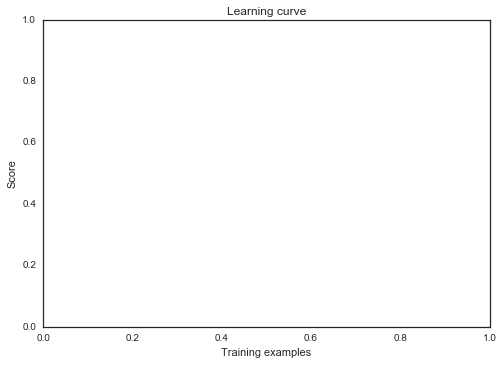

In [79]:
cv = model_selection.ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
title = "Learning curve"
rf = RandomForestClassifier(n_estimators=100, max_features=5, min_samples_leaf=3)
plot_learning_curve(rf, title, data, target, 
                    cv=cv, n_jobs=4)

# 2. Clustering

We group the referee informations by player and since we did it already in the last part, we can reuse group.

In [263]:
grouped.head()

,weightMeanIAT,yellowCards,defeats,yellowReds,position,height,age,meanIAT,skin_nonorm,goals,...,meanExp,refCountry,redCards,ties,refNum,seExp,skin,skin_difference,games,weight
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,2.861858e-06,-0.346780,0.306836,-0.108671,1,-0.018675,1.371299,0.346459,0.5,-0.316979,...,0.494575,37,-0.112016,0.317084,166,0.027536,-0.549090,1.800031,0.263530,-0.749386
aaron-hunt,3.807995e-06,0.030080,0.207666,-0.108671,0,0.128306,-0.225191,0.348818,0.5,0.288572,...,0.449220,25,-0.023386,0.019149,99,0.002506,-0.549090,1.800031,0.111152,-0.470302
aaron-lennon,3.081554e-06,-0.353528,0.141837,-0.108671,11,-2.517367,-0.453261,0.345893,1.0,-0.049463,...,0.491482,28,-0.112016,0.214040,101,0.008914,-0.115715,-0.547478,0.302460,-1.865721
aaron-ramsey,5.548255e-06,-0.123403,-0.198705,-0.108671,3,-0.606603,-1.365542,0.346821,0.0,0.022593,...,0.514693,37,-0.027647,-0.272310,104,0.104541,-0.982466,-0.547478,-0.138411,-0.051676
abdelhamid-el-kaoutari,4.243206e-07,-0.222989,0.158379,0.864236,1,-0.312639,-1.137472,0.331600,1.0,-0.345761,...,0.335587,11,0.362271,0.319503,37,0.023426,-0.115715,-0.547478,0.099263,-0.470302


In [113]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

We now compute the silhouette score and remove iteratively features. We keep track of 2 score, the one by silhouette score of the clusterisation by k-mean and its own labels, and the one corresponding to the proportion of correctly partitionned data along the skin value (accuracy = max(partition_accuracy, 1-partition_accuracy) split at skin value = 2.0)

In [264]:
skin_labels = (grouped['skin_nonorm'] < 2.0).astype(int) 
skin_labels.head()

playerShort
aaron-hughes              1
aaron-hunt                1
aaron-lennon              1
aaron-ramsey              1
abdelhamid-el-kaoutari    1
Name: skin_nonorm, dtype: int64

We define the cluster method with the data as parameter

In [115]:
def cluster(X):
    kmeans_model = KMeans(n_clusters=2, random_state=1).fit(X)
    labels = kmeans_model.labels_
    
    silhouette_unsupervised = silhouette_score(X, labels)
    np.mean(silhouette_unsupervised)
    eq = skin_labels == labels
    mean = np.mean(eq)
    skin_partition = max(mean, 1-mean)
    
    return  silhouette_unsupervised, skin_partition

The first iterative ablation of the features is done according to the features importance we found in the previous part. It should logically give good results.

In [266]:
silhouettes_unsupervised = []
skin_partitions = []
feature_number = []

columns = sorted_features
#We always drop skin_nonorm. It was only used for labeling before standardization
for i in range(len(columns)):
    silhouette_unsupervised, skin_partitionning = cluster(grouped[columns])
    
    silhouettes_unsupervised.append(silhouette_unsupervised)
    skin_partitions.append(skin_partitionning )
    
    feature_number.append(len(columns))
    print(silhouette_unsupervised, skin_partitionning, columns)
    print("REMOVED FEATURE: ", columns[-1])
    print()
    print()
    columns = columns[:-1]

0.530481692863 0.569085173502 ['seExp', 'seIAT', 'meanIAT', 'meanExp', 'refNum', 'victories', 'goals', 'yellowCards', 'games', 'defeats', 'ties', 'refCountry', 'redCards', 'position', 'height', 'age', 'weight', 'weightMeanIAT', 'weightMeanExp', 'yellowReds']
REMOVED FEATURE:  yellowReds


0.530500302178 0.569085173502 ['seExp', 'seIAT', 'meanIAT', 'meanExp', 'refNum', 'victories', 'goals', 'yellowCards', 'games', 'defeats', 'ties', 'refCountry', 'redCards', 'position', 'height', 'age', 'weight', 'weightMeanIAT', 'weightMeanExp']
REMOVED FEATURE:  weightMeanExp


0.530500302178 0.569085173502 ['seExp', 'seIAT', 'meanIAT', 'meanExp', 'refNum', 'victories', 'goals', 'yellowCards', 'games', 'defeats', 'ties', 'refCountry', 'redCards', 'position', 'height', 'age', 'weight', 'weightMeanIAT']
REMOVED FEATURE:  weightMeanIAT


0.530500302178 0.569085173502 ['seExp', 'seIAT', 'meanIAT', 'meanExp', 'refNum', 'victories', 'goals', 'yellowCards', 'games', 'defeats', 'ties', 'refCountry', 'redCards

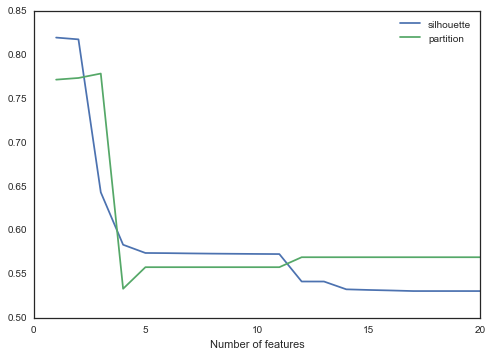

In [267]:
plt.plot(feature_number, silhouettes_unsupervised, label='silhouette');
plt.plot(feature_number, skin_partitions, label='partition');
plt.xlabel('Number of features');
plt.legend();

We can see that the silhouette goes up as the number of features go down (easier to cluster). 
We could think that ['seExp', 'seIAT', 'meanIAT', 'meanExp'] give good enough silhouette and partition scores.

In [280]:
print(skin_labels.value_counts())
1200/(1200+385)

1    1200
0     385
Name: skin_nonorm, dtype: int64


0.7570977917981072

But we notice that just outputing everything under 1 category would result in a 75% accuracy, which is only a bit less than the best paritionning accuracy achieved here. Way less spectacular.

Now let's take another approach and instead of removing features iteratively based on the feature importance found in the previous part, we're gonna remove the feature such that it maximizes the silhouette score at the next iteration

In [281]:

silhouettes_unsupervised = []
skin_partitions = []
feature_number = []

columns = sorted_features

#We always drop skin_nonorm. It was only used for labeling before standardization
for i in range(len(columns)):
    silhouette_unsupervised, skin_partitionning = cluster(grouped[columns])
    
    silhouettes_unsupervised.append(silhouette_unsupervised)
    skin_partitions.append(skin_partitionning )
    

    feature_number.append(len(columns))
    print(silhouette_unsupervised, skin_partitionning, columns)
    
    if len(columns) == 1:
        break;
    
    max_silhouette = 0
    j = -1
    
    for i in range(len(columns)):
        hole_columns = columns[:i] + columns[i+1:]
        silhouette, _ = cluster(grouped[hole_columns]) 
        if silhouette > max_silhouette:
            j = i
            max_silhouette = silhouette
            

    print("REMOVED FEATURE: ", j, columns[j])
    print()
    print()
    columns = columns[:j] + columns[j+1:]

0.530481692863 0.569085173502 ['seExp', 'seIAT', 'meanIAT', 'meanExp', 'refNum', 'victories', 'goals', 'yellowCards', 'games', 'defeats', 'ties', 'refCountry', 'redCards', 'position', 'height', 'age', 'weight', 'weightMeanIAT', 'weightMeanExp', 'yellowReds']
REMOVED FEATURE:  11 refCountry


0.554783519573 0.557728706625 ['seExp', 'seIAT', 'meanIAT', 'meanExp', 'refNum', 'victories', 'goals', 'yellowCards', 'games', 'defeats', 'ties', 'redCards', 'position', 'height', 'age', 'weight', 'weightMeanIAT', 'weightMeanExp', 'yellowReds']
REMOVED FEATURE:  12 position


0.568202609457 0.557728706625 ['seExp', 'seIAT', 'meanIAT', 'meanExp', 'refNum', 'victories', 'goals', 'yellowCards', 'games', 'defeats', 'ties', 'redCards', 'height', 'age', 'weight', 'weightMeanIAT', 'weightMeanExp', 'yellowReds']
REMOVED FEATURE:  12 height


0.569604038994 0.557728706625 ['seExp', 'seIAT', 'meanIAT', 'meanExp', 'refNum', 'victories', 'goals', 'yellowCards', 'games', 'defeats', 'ties', 'redCards', 'age', 'w

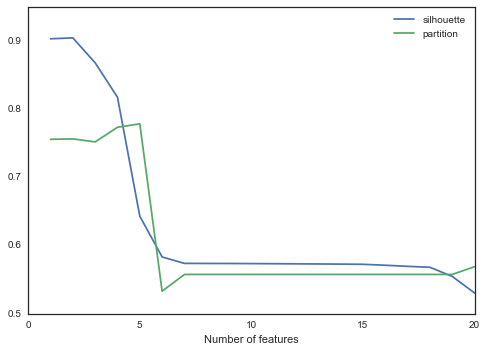

In [282]:
plt.plot(feature_number, silhouettes_unsupervised, label='silhouette');
plt.plot(feature_number, skin_partitions, label='partition');
plt.xlabel('Number of features');
plt.legend();

Silhouette reach a higher score but accuracy stays the same. We can conclude that clusterisation doesn't reveal any significative correlation with Skin color. 


Let's now try by adding the skin feature for sanity check if there is now a clear partition.

In [283]:
silhouettes_unsupervised = []
skin_partitions = []
feature_number = []

columns = ['skin', 'skin_difference'] + sorted_features
#We always drop skin_nonorm. It was only used for labeling before standardization
for i in range(len(columns)):
    silhouette_unsupervised, skin_partitionning = cluster(grouped[columns])
    
    silhouettes_unsupervised.append(silhouette_unsupervised)
    skin_partitions.append(skin_partitionning )
    
    feature_number.append(len(columns))
    print(silhouette_unsupervised, skin_partitionning, columns)
    print("REMOVED FEATURE: ", columns[-1])
    print()
    print()
    columns = columns[:-1]

0.529075383878 0.569085173502 ['skin', 'skin_difference', 'seExp', 'seIAT', 'meanIAT', 'meanExp', 'refNum', 'victories', 'goals', 'yellowCards', 'games', 'defeats', 'ties', 'refCountry', 'redCards', 'position', 'height', 'age', 'weight', 'weightMeanIAT', 'weightMeanExp', 'yellowReds']
REMOVED FEATURE:  yellowReds


0.529093535491 0.569085173502 ['skin', 'skin_difference', 'seExp', 'seIAT', 'meanIAT', 'meanExp', 'refNum', 'victories', 'goals', 'yellowCards', 'games', 'defeats', 'ties', 'refCountry', 'redCards', 'position', 'height', 'age', 'weight', 'weightMeanIAT', 'weightMeanExp']
REMOVED FEATURE:  weightMeanExp


0.529093535491 0.569085173502 ['skin', 'skin_difference', 'seExp', 'seIAT', 'meanIAT', 'meanExp', 'refNum', 'victories', 'goals', 'yellowCards', 'games', 'defeats', 'ties', 'refCountry', 'redCards', 'position', 'height', 'age', 'weight', 'weightMeanIAT']
REMOVED FEATURE:  weightMeanIAT


0.529093535491 0.569085173502 ['skin', 'skin_difference', 'seExp', 'seIAT', 'meanIAT', '

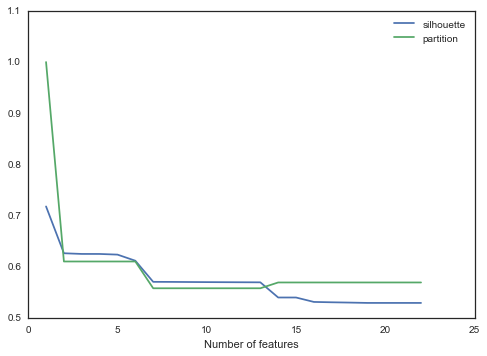

In [261]:
plt.plot(feature_number, silhouettes_unsupervised, label='silhouette');
plt.plot(feature_number, skin_partitions, label='partition');
plt.xlabel('Number of features');
plt.legend();

Surprisingly, the paritition doesn't improve significatively until we only keep the skin related features. Then it achieves not so surprisingly a perfect partition.

Let's now try to have some visualisation of the effect of clusterisation based on the two relevant features:
['seExp', 'seIAT']

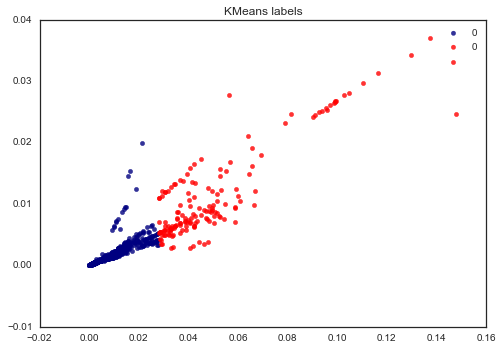

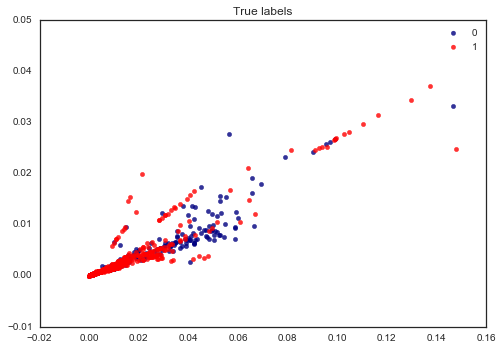

In [286]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


X = grouped[['seExp', 'seIAT']]
kmeans_model = KMeans(n_clusters=2, random_state=1).fit(X)
labels = kmeans_model.labels_

skin_labels_nd = skin_labels.as_matrix()

Xnd = X.as_matrix()

x1 = Xnd[labels == 0, 0]
y1 = Xnd[labels == 0, 1]
x2 = Xnd[labels == 1, 0]
y2 = Xnd[labels == 1, 1]

plt.figure()
plt.scatter(x1, y1, color='navy', alpha=.8, label='0')
plt.scatter(x2, y2, color='red', alpha=.8, label='0')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('KMeans labels')


x1 = Xnd[skin_labels_nd == 0, 0]
y1 = Xnd[skin_labels_nd == 0, 1]
x2 = Xnd[skin_labels_nd == 1, 0]
y2 = Xnd[skin_labels_nd == 1, 1]

plt.figure()
plt.scatter(x1, y1, color='navy', alpha=.8, label='0')
plt.scatter(x2, y2, color='red', alpha=.8, label='1')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('True labels')
plt.show()


In [ ]:
We can notice that there seems to be a pattern